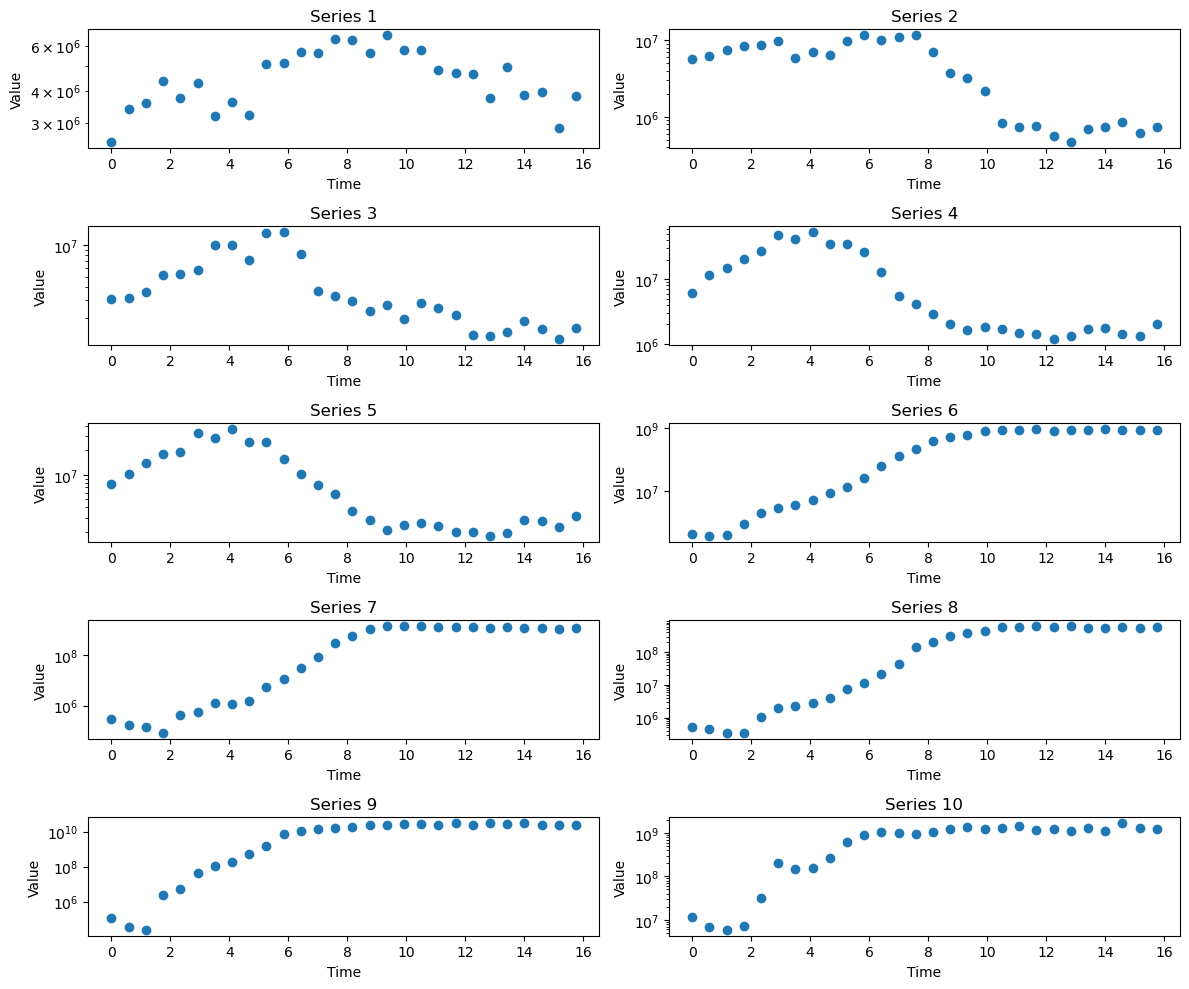

In [1]:
import scipy.io
import matplotlib.pyplot as plt

# Load the .mat file
mat_data = scipy.io.loadmat('./../data/qpcr.mat')

# Access the data struct
data = mat_data['data']

# Extract time data (assuming it's stored in data.xdata)
time = data['xdata'][0][0]

# Extract the 10 time series (assuming they are stored in data.ydata)
time_series = data['ydata'][0][0]

# Create subplots in a (5,2) grid
fig, axs = plt.subplots(5, 2, figsize=(12, 10))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()

# Plot each time series on a logarithmic scale
for i in range(10):
    axs[i].plot(time, time_series[:, i],'o')
    axs[i].set_title(f'Series {i + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_yscale('log')


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### ODE based model.

In [4]:
import numpy as np
from numba import njit


## inside this function, every term has been made into a (N.M)-numpy array for matrix calculations



def seivd(y,t,
          r1,r2,r3,r4,r5,
         beta12,beta21,beta22,beta23,beta33,beta44,beta45,beta54,beta55,
         phi12,phi21,phi22,phi23,phi33,phi44,phi45,phi54,phi55,
         tau12,tau21,tau22,tau23,tau33,tau44,tau45,tau54,tau55,
          Dc1,Dc2,Dc3,Dc4,Dc5,
         NE,NH,NV):
    
    
    # make these arrays (N,) --> (N,1) arrays, ie, vectors
    y = y.reshape(-1,1)
    
    # unpack variables 
    # these variables vary over time
    
    S = y[0:NH] # 1d vector
    Emat = y[NH : NH + NH*NV*NE]  #should be a 3d tensor
    Emat = Emat.reshape((NE,NH,NV)) # reshaped into a 3d tensor
    # Emat[i,:,:] is the i'th box -- so first element for the box number
    Imat = y[NH + NH*NV*NE : NH + NH*NV*NE + NH*NV] #2d matrix
    Imat = Imat.reshape((NH,NV))
    V = y[NH + NH*NV*NE + NH*NV : NH + NH*NV*NE + NH*NV + NV ]  #1d matrix
    D = y[NH + NH*NV*NE + NH*NV + NV] # a number
    
    

    
    
    # pack parameters into matrices.
    r = np.array([[r1,r2,r3,r4,r5]]).T #transposed it, so this is a column vector now.
    
    beta = np.array([[0, beta12, 0, 0, 0 ],
                     [beta21, beta22, beta23, 0, 0],
                     [0, 0, beta33, 0 , 0],
                     [0, 0, 0, beta44, beta45],
                     [0, 0, 0, beta54, beta55]])
    
    tau = np.array([[0, tau12, 0, 0, 0 ],
                     [tau21, tau22, tau23, 0, 0],
                     [0, 0, tau33, 0 , 0],
                     [0, 0, 0, tau44, tau45],
                     [0, 0, 0, tau54, tau55]])
    
    phi = np.array([[0, phi12, 0, 0, 0 ],
                     [phi21, phi22, phi23, 0, 0],
                     [0, 0, phi33, 0 , 0],
                     [0, 0, 0, phi44, phi45],
                     [0, 0, 0, phi54, phi55]])
    

    
    Dc = np.array([[Dc1,Dc2,Dc3,Dc4,Dc5]]).T
    #etaeff = (NE+1) * np.where(tau != 0, 1 / tau, 0)  # tested: works fine
    etaeff = (NE+1)*np.array([[0, 1/tau12, 0, 0, 0 ],
                     [1/tau21, 1/tau22, 1/tau23, 0, 0],
                     [0, 0, 1/tau33, 0 , 0],
                     [0, 0, 0, 1/tau44, 1/tau45],
                     [0, 0, 0, 1/tau54, 1/tau55]])
    

    
    #set up variables for the differential equation
    Sdeb = S/(1+(D/Dc)**2) #element wise division
    N = S + np.sum(Emat,axis=0)@np.ones((NV,1)) + Imat@np.ones((NV,1))  #sum of all the different types of host cells (is a column vector of same size as S)
    # we summed the 0 axis, for boxes, then we multiplied with a col vector of size NV, means summed at each row level
    # means at each row, summed elements of each columns, so viruses summer up, and we net N_i for each host
    Ndeb = N/(1+(D/Dc)**2) #number of host of each species scaled by debris factor.
    
    
    
    ## the differential eqauations
    dS = r*S - Sdeb * (phi@V) #host change
    
    dEmat = np.zeros((NE,NH,NV)) # initializing as zero tensor, otherwise will give undefined error
    #dEmat[0,:,:] = Sdeb * ((phi*beta)@V) - etaeff*Emat[0,:,:]
    #dEmat[0,:,:] =  phi*(Sdeb@V.T) - etaeff*Emat[0,:,:]
    dEmat[0,:,:] = (phi*(Sdeb@V.T) - etaeff*Emat[0,:,:]).reshape((NH, NV))

    
    #vectorize this
    dEmat[1:,:,:] = etaeff * (-Emat[1:,:,:] + Emat[0:-1,:,:])  # note the signs 
    dImat = etaeff * (Emat[NE-1,:,:] - Imat) #element wise multiplication
    
    # for the viruses we need to sum up all the row elements for each column 
    # sum_{j=1}^{NH} Imat'_{kj} = Imat_k 
    #for the part of viral ads, transpose phi and multiply, as sum over the hosts
    dV = (beta * etaeff * Imat).T @ np.ones((NH,1)) - V * (phi.T @ Ndeb)
    dD = np.sum(etaeff* Imat)
    
    
    dydt = np.concatenate((dS.flatten(), dEmat.flatten(), dImat.flatten(), dV.flatten(), [dD]))
    return dydt

In [5]:
#t = np.linspace(0, 15.75,150)

t = np.arange(0,15.75,0.01)

# creating initial conditions

NE = 200
NH = 5
NV = 5

y0 = np.zeros((NH + NH*NV*NE + NH*NV + NV + 1))

y0[0] = 2.5111e+06
y0[1] = 5.6423e+06
y0[2] = 3.0257e+06
y0[3] = 6.205e+06
y0[4] = 7.7533e+06

y0[-6] = 4.2887e+05
y0[-5] = 2.8689e+05
y0[-4] = 5.28e+05
y0[-3] = 1.1033e+05
y0[-2] = 1.151e+07


from scipy.integrate import odeint

# parameter values


r1 = 0.18
r2 = 0.25
r3 = 0.3 
r4 = 0.68
r5 = 0.52

beta12 = 1.7231
beta21 = 200.7512
beta22 = 205.9496
beta23 = 100.1492
beta33 = 20.7017
beta44 = 522 
beta45 = 60.2599
beta54 = 485.1209
beta55 = 50.9918

phi12 = 0.6e-7
phi21 = 0.18e-7
phi22 = 0.8e-7
phi23 = 0.2e-7
phi33 = 0.6e-7
phi44 = 0.7e-7
phi45 = 0.1285e-7
phi54 = 0.6e-7
phi55 = 0.22e-7

tau12 = 3
tau21 = 1.7
tau22 = 2.7
tau23 = 2.3
tau33 = 2
tau44 = 1.8
tau45 = 4.7
tau54 = 2.3
tau55 = 2

Dc1 = 5e6 
Dc2 = 6.13e6
Dc3 = 16e6 
Dc4 = 17.3e5
Dc5 = 15.5e5


y = odeint(seivd, y0, t, args=(r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5, NE, NH, NV),
atol=1e-8, rtol=1e-8)


   


In [6]:
# parameter values


r1 = 0.18
r2 = 0.25
r3 = 0.3 
r4 = 0.68
r5 = 0.52

beta12 = 1.7231
beta21 = 200.7512
beta22 = 205.9496
beta23 = 100.1492
beta33 = 20.7017
beta44 = 522 
beta45 = 60.2599
beta54 = 485.1209
beta55 = 50.9918

phi12 = 0.6e-7
phi21 = 0.18e-7
phi22 = 0.8e-7
phi23 = 0.2e-7
phi33 = 0.6e-7
phi44 = 0.7e-7
phi45 = 0.1285e-7
phi54 = 0.6e-7
phi55 = 0.22e-7

tau12 = 3
tau21 = 1.7
tau22 = 2.7
tau23 = 2.3
tau33 = 2
tau44 = 1.8
tau45 = 4.7
tau54 = 2.3
tau55 = 2

Dc1 = 5e6 
Dc2 = 6.13e6
Dc3 = 16e6 
Dc4 = 17.3e5
Dc5 = 15.5e5


def simulate_ode(t,r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5):
    NE = 200
    NH = 5
    NV = 5

    y0 = np.zeros((NH + NH*NV*NE + NH*NV + NV + 1))

    y0[0] = 2.5111e+06
    y0[1] = 5.6423e+06
    y0[2] = 3.0257e+06
    y0[3] = 6.205e+06
    y0[4] = 7.7533e+06

    y0[-6] = 4.2887e+05
    y0[-5] = 2.8689e+05
    y0[-4] = 5.28e+05
    y0[-3] = 1.1033e+05
    y0[-2] = 1.151e+07
    
    y = odeint(seivd, y0, t, args=(r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5, NE, NH, NV),
atol=1e-8, rtol=1e-8)
    
    host = y[:,0:NH] + np.sum(np.sum( y[:,NH : NH + NH*NV*NE].reshape((len(t),200,5,5)),axis = 3),axis=1) + np.sum(y[:,NH + NH*NV*NE : NH + NH*NV*NE + NH*NV].reshape(len(t),5,5),axis = 2 ) 
    virus = y[:,-1-NV:-1]
    
    return host,virus


host,virus = simulate_ode(time.flatten(),r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5)


In [ ]:
time.flatten().shape

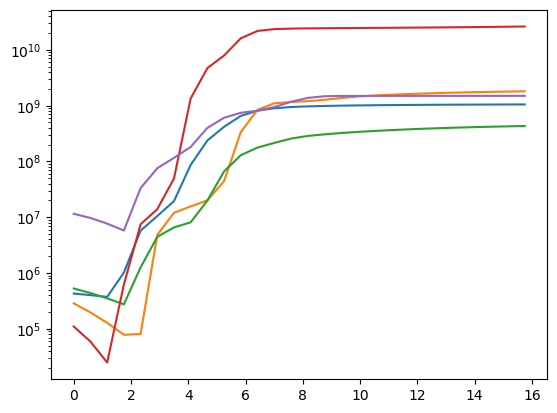

In [7]:
import matplotlib.pyplot as plt
plt.plot(time.flatten(),virus,'-')
plt.yscale('log')
plt.show()

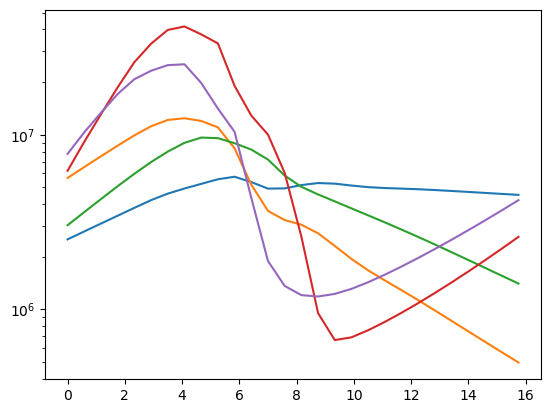

In [8]:
plt.plot(time.flatten(),host[:,0:5],'-')
plt.yscale('log')
plt.show()

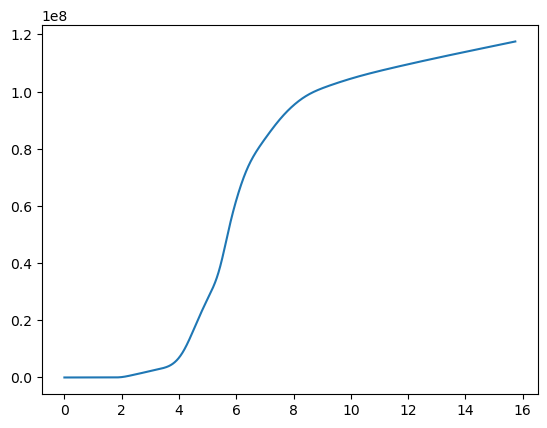

In [9]:
plt.plot(t,y[:,-1],'-')
plt.show()

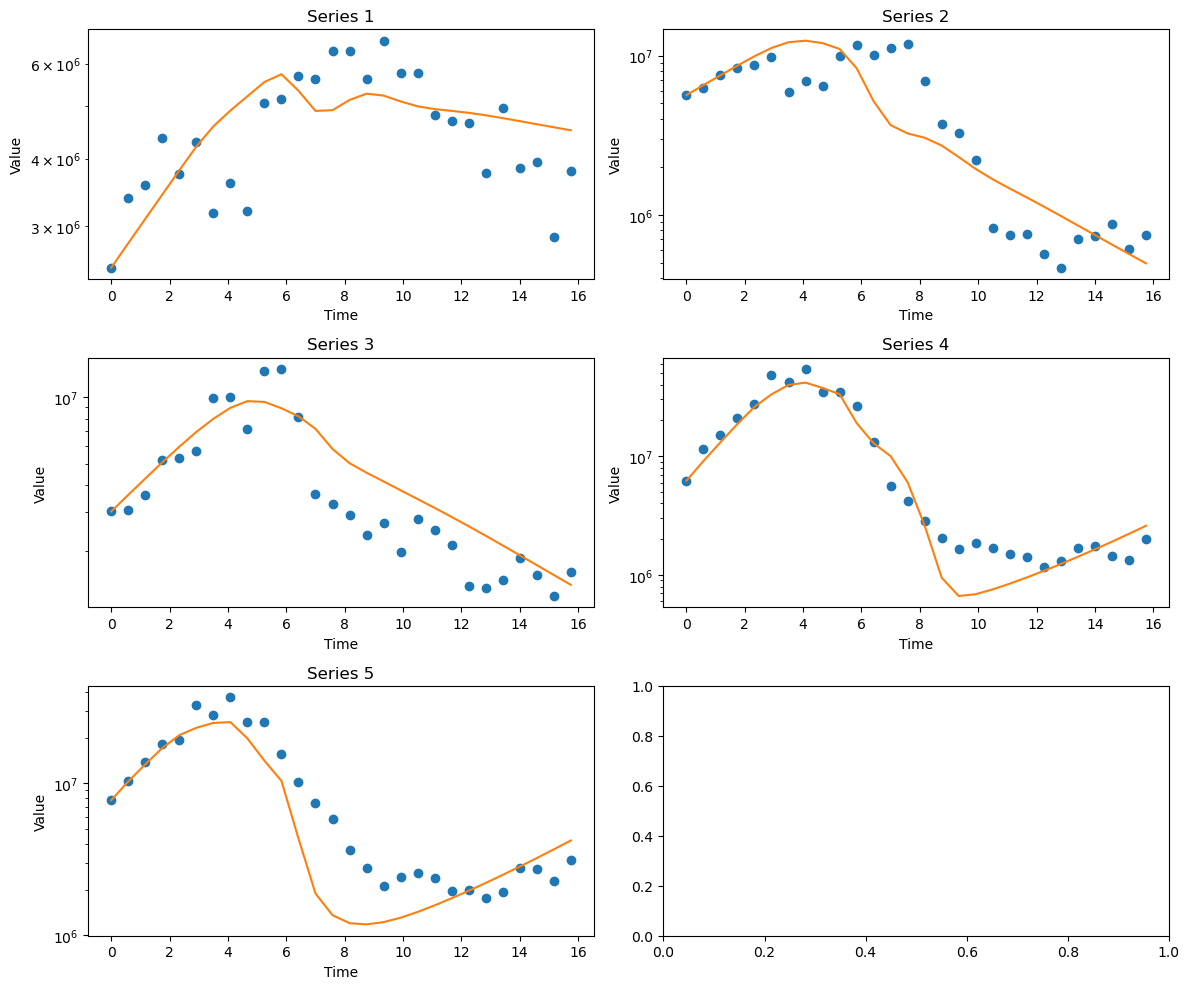

In [11]:
# Create subplots in a (5,1) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()


# Plot each time series on a logarithmic scale
for i in range(5):
    axs[i].plot(time, time_series[:, i],'o')
    axs[i].plot(time,host[:,i],'-')
    axs[i].set_title(f'Series {i + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_yscale('log')
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

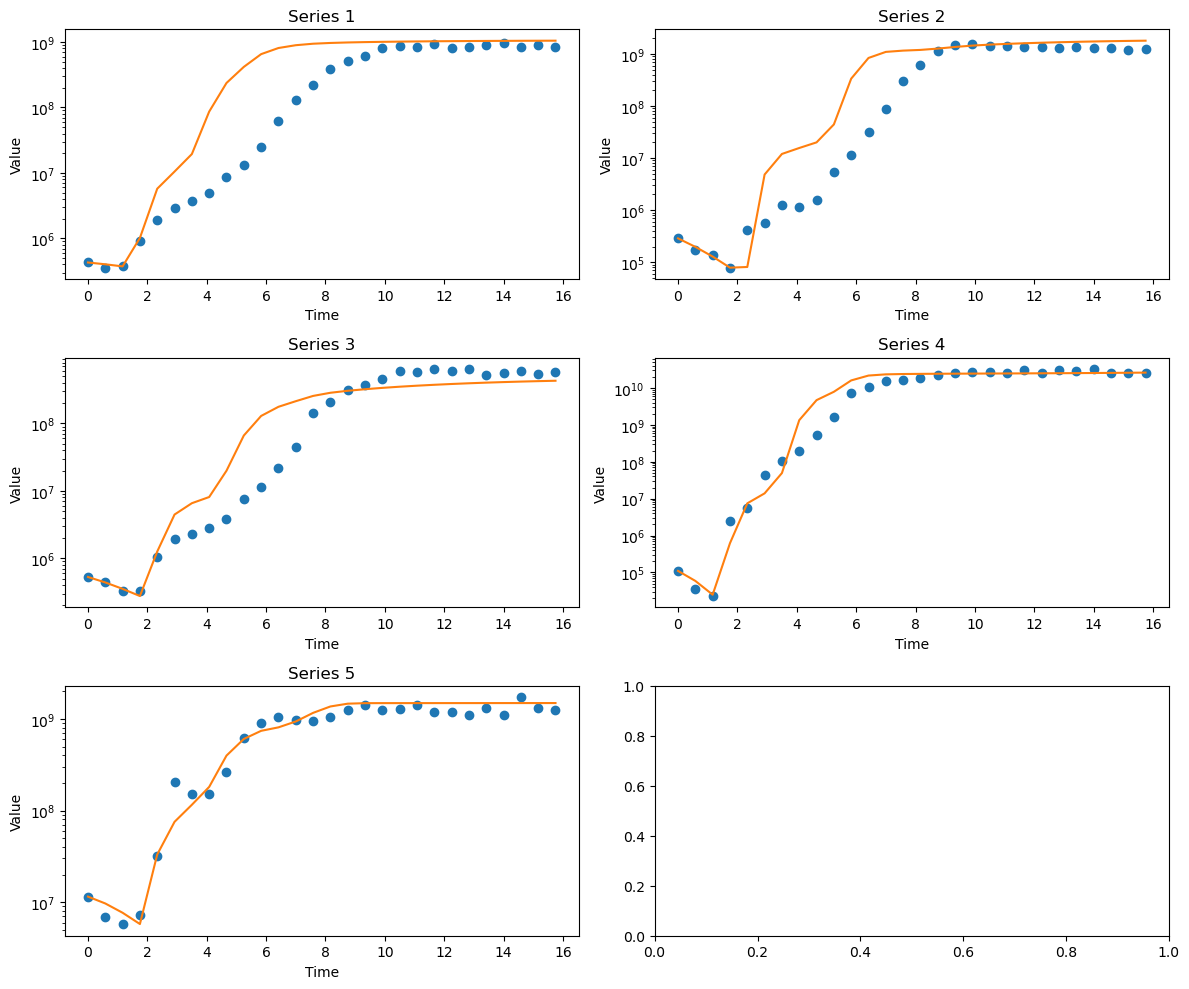

In [13]:
# Create subplots in a (5,2) grid
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axs array to make it easier to work with
axs = axs.flatten()


# Plot each time series on a logarithmic scale
for i in range(5):
    axs[i].plot(time, time_series[:, i+5],'o')
    axs[i].plot(time.flatten(),virus[:,i],'-')
    axs[i].set_title(f'Series {i + 1}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].set_yscale('log')
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Bayesian inference using pymc

In [14]:
import pymc as pm

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.2+3.gaccabdfb


In [16]:

az.style.use("arviz-darkgrid")

In [27]:
with pm.Model() as model:
    
    # Priors for parameters
    
    r1 = pm.Normal("r1", mu = 0.18, sigma = 0.2)
    r2 = pm.Normal("r2", mu = 0.25, sigma = 0.2)
    r3 = pm.Normal("r3", mu = 0.3, sigma = 0.2)
    r4 = pm.Normal("r4", mu = 0.68, sigma = 0.2)
    r5 = pm.Normal("r5", mu = 0.52, sigma = 0.2)
    
    beta12 = pm.Normal("beta12", mu = 1.7, sigma = 1)
    beta21 = pm.Normal("beta21", mu = 200, sigma = 100)
    beta22 = pm.Normal("beta22", mu = 206, sigma = 100)
    beta23 = pm.Normal("beta23", mu = 100, sigma = 100) 
    beta33 = pm.Normal("beta33", mu = 20, sigma = 20)
    beta44 = pm.Normal("beta44", mu = 522, sigma = 200)
    beta45 = pm.Normal("beta45", mu = 60, sigma = 50)
    beta54 = pm.Normal("beta54", mu = 485, sigma = 200)
    beta55 = pm.Normal("beta55", mu = 50, sigma = 40)
    

    phi12 = pm.Normal("phi12", mu = (0.6e-7), sigma = 1e-8)
    phi21 = pm.Normal("phi21", mu = (0.18e-7), sigma = 1e-8)
    phi22 = pm.Normal("phi22", mu = (0.8e-7), sigma = 1e-8)
    phi23 = pm.Normal("phi23", mu = (0.2e-7), sigma = 1e-8)
    phi33 = pm.Normal("phi33", mu = (0.6e-7), sigma = 1e-8)
    phi44 = pm.Normal("phi44", mu = (0.7e-7), sigma = 1e-8)
    phi45 = pm.Normal("phi45", mu = (0.1285e-7), sigma = 1e-8)
    phi54 = pm.Normal("phi54", mu = (0.6e-7), sigma = 1e-8)
    phi55 = pm.Normal("phi55", mu = (0.22e-7), sigma = 1e-8)
    
    tau12 = pm.Normal("tau12", mu = 3, sigma = 2)
    tau21 = pm.Normal("tau21", mu = 1.7, sigma = 2)
    tau22 = pm.Normal("tau22", mu = 2.7, sigma = 2)
    tau23 = pm.Normal("tau23", mu = 2.3, sigma = 2) 
    tau33 = pm.Normal("tau33", mu = 2, sigma = 2)
    tau44 = pm.Normal("tau44", mu = 1.8, sigma = 2)
    tau45 = pm.Normal("tau45", mu = 4.7, sigma = 2)
    tau54 = pm.Normal("tau54", mu = 2.3, sigma = 2)
    tau55 = pm.Normal("tau55", mu = 2, sigma = 4)
    
    Dc1 = pm.Normal("Dc1", mu = 5e6 ,sigma = 5e5)
    Dc2 = pm.Normal("Dc2", mu = 6.13e6 ,sigma = 5e5)
    Dc3 = pm.Normal("Dc3", mu = 16e6 ,sigma = 5e5)
    Dc4 = pm.Normal("Dc4", mu = 17.3e5 ,sigma = 5e5)
    Dc5 = pm.Normal("Dc5", mu = 15.5e5 ,sigma = 5e5)
    
    
    def simulate_ode(t,r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5):
        NE = 200
        NH = 5
        NV = 5

        y0 = np.zeros((NH + NH*NV*NE + NH*NV + NV + 1))

        y0[0] = 2.5111e+06
        y0[1] = 5.6423e+06
        y0[2] = 3.0257e+06
        y0[3] = 6.205e+06
        y0[4] = 7.7533e+06

        y0[-6] = 4.2887e+05
        y0[-5] = 2.8689e+05
        y0[-4] = 5.28e+05
        y0[-3] = 1.1033e+05
        y0[-2] = 1.151e+07
    
        y = odeint(seivd, y0, t, args=(r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5, NE, NH, NV),
atol=1e-8, rtol=1e-8)
    
        host = y[:,0:NH] + np.sum(np.sum( y[:,NH : NH + NH*NV*NE].reshape((len(t),200,5,5)),axis = 3),axis=1) + np.sum(y[:,NH + NH*NV*NE : NH + NH*NV*NE + NH*NV].reshape(len(t),5,5),axis = 2 ) 
        virus = y[:,-1-NV:-1]
    
        return host,virus


        #host,virus = simulate_ode(time.flatten(),r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5)
        #sigma = pm.Normal("sigma", 10)

        # Likelihood for observed data with shared sigma
        #obs = pm.InverseGamma("obs", mu=[host, virus], sigma=sigma, observed=[time_series[:, 0:5], time_series[:, 5:10]])
        
        # Define your likelihood
        sigma = pm.InverseGamma("sigma", alpha=1, beta=1)
        obs = pm.Normal("obs", mu=simulate_ode(time, r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5), sigma=sigma, observed=time_series)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [r1, r2, r3, r4, r5, beta12, beta21, beta22, beta23, beta33, beta44, beta45, beta54, beta55, phi12, phi21, phi22, phi23, phi33, phi44, phi45, phi54, phi55, tau12, tau21, tau22, tau23, tau33, tau44, tau45, tau54, tau55, Dc1, Dc2, Dc3, Dc4, Dc5]


Sampling 2 chains for 10_000 tune and 2_000 draw iterations (20_000 + 4_000 draws total) took 2003 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/Users/rdey33/anaconda3/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (37), generating only 20 plots
  warnings.warn(


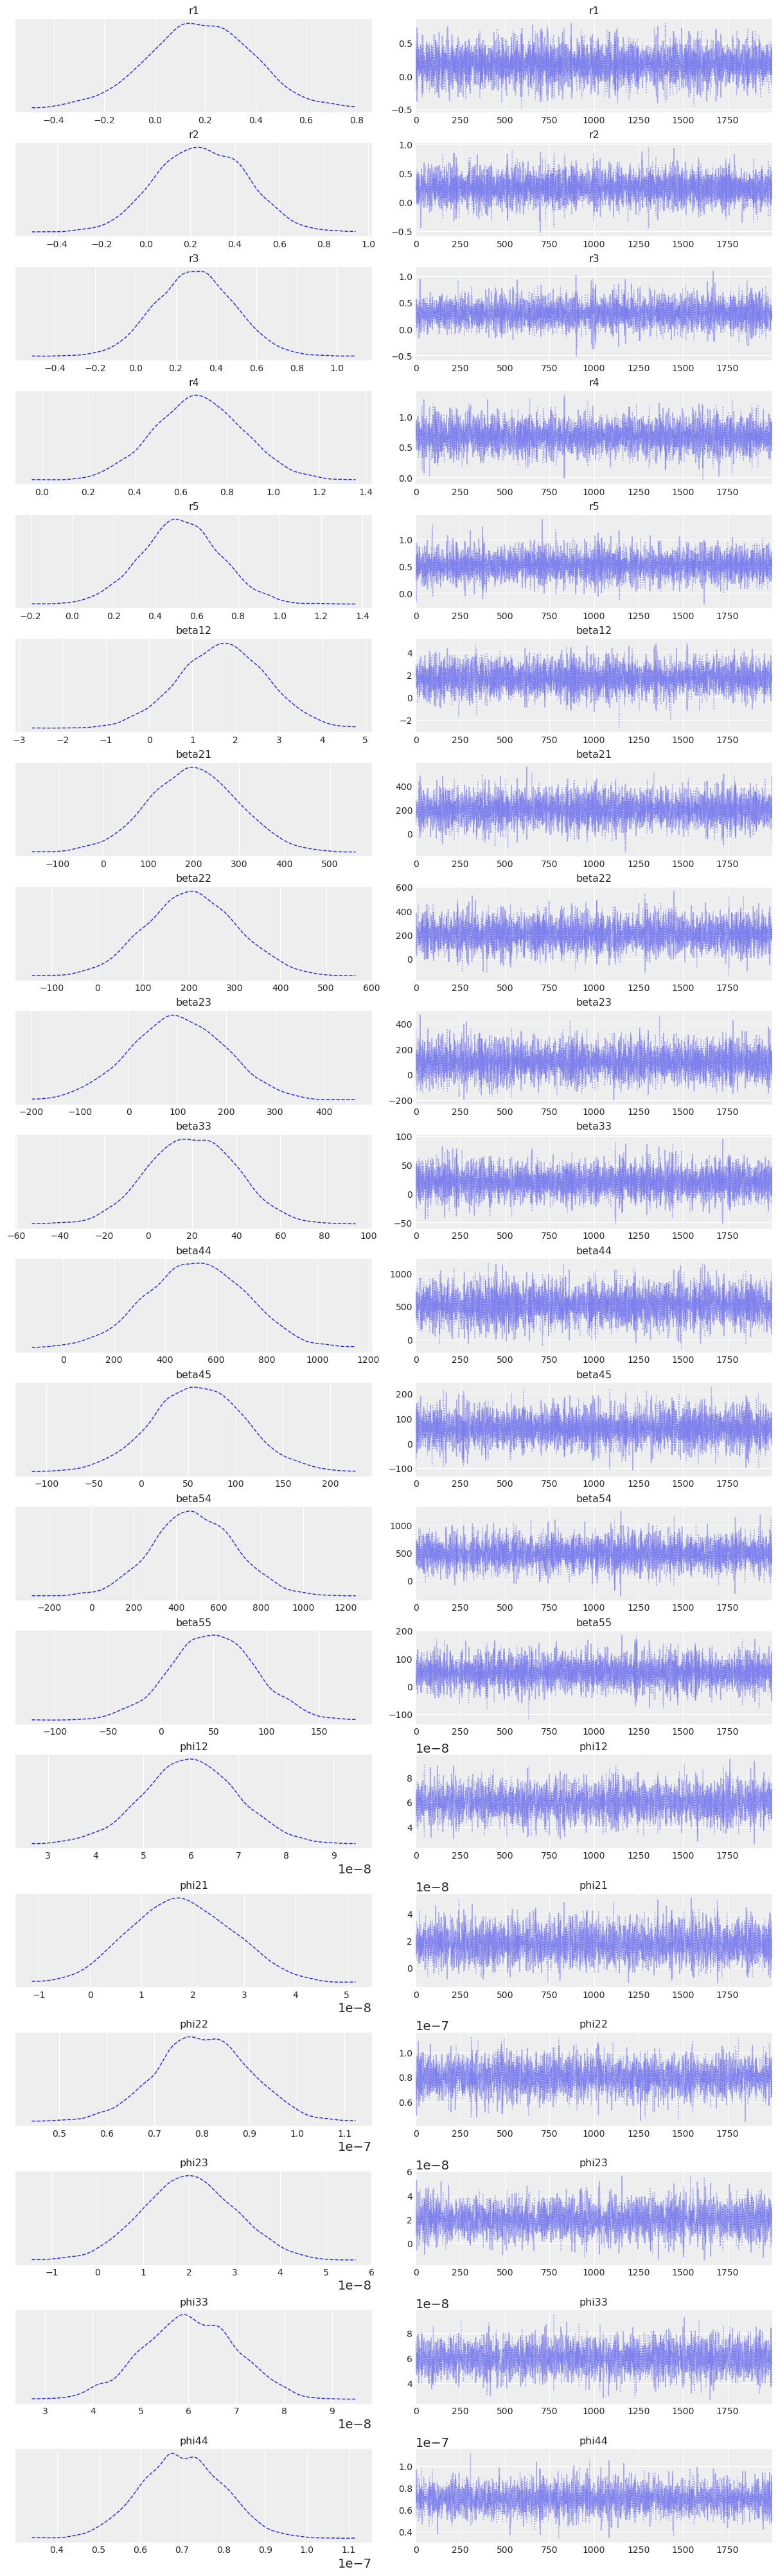

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r1,0.18,0.21,-0.21,0.56,0.00,0.00,7770.05,2593.21,1.0
r2,0.25,0.20,-0.11,0.63,0.00,0.00,7890.52,2458.30,1.0
r3,0.30,0.20,-0.07,0.66,0.00,0.00,9047.56,2918.81,1.0
r4,0.68,0.19,0.31,1.04,0.00,0.00,6822.83,2648.85,1.0
r5,0.52,0.19,0.16,0.89,0.00,0.00,7156.88,2327.09,1.0
beta12,1.69,1.01,-0.25,3.59,0.01,0.01,6925.35,2398.62,1.0
beta21,199.22,99.23,13.92,385.85,1.05,0.92,8859.74,2305.26,1.0
beta22,206.10,100.17,22.64,396.03,1.18,1.09,7223.28,2311.16,1.0
beta23,100.49,97.54,-82.92,283.11,1.12,1.14,7537.45,2809.42,1.0
beta33,19.94,20.10,-19.00,55.69,0.23,0.25,7797.75,2665.54,1.0


In [28]:
sampler = "Slice Sampler"
with model:
    # Perform Bayesian inference using NUTS
    trace = pm.sample(draws=2000, tune=10000, cores=1,return_inferencedata=True)

az.plot_trace(trace, combined=True);
plt.show()
az.summary(trace, round_to=2)


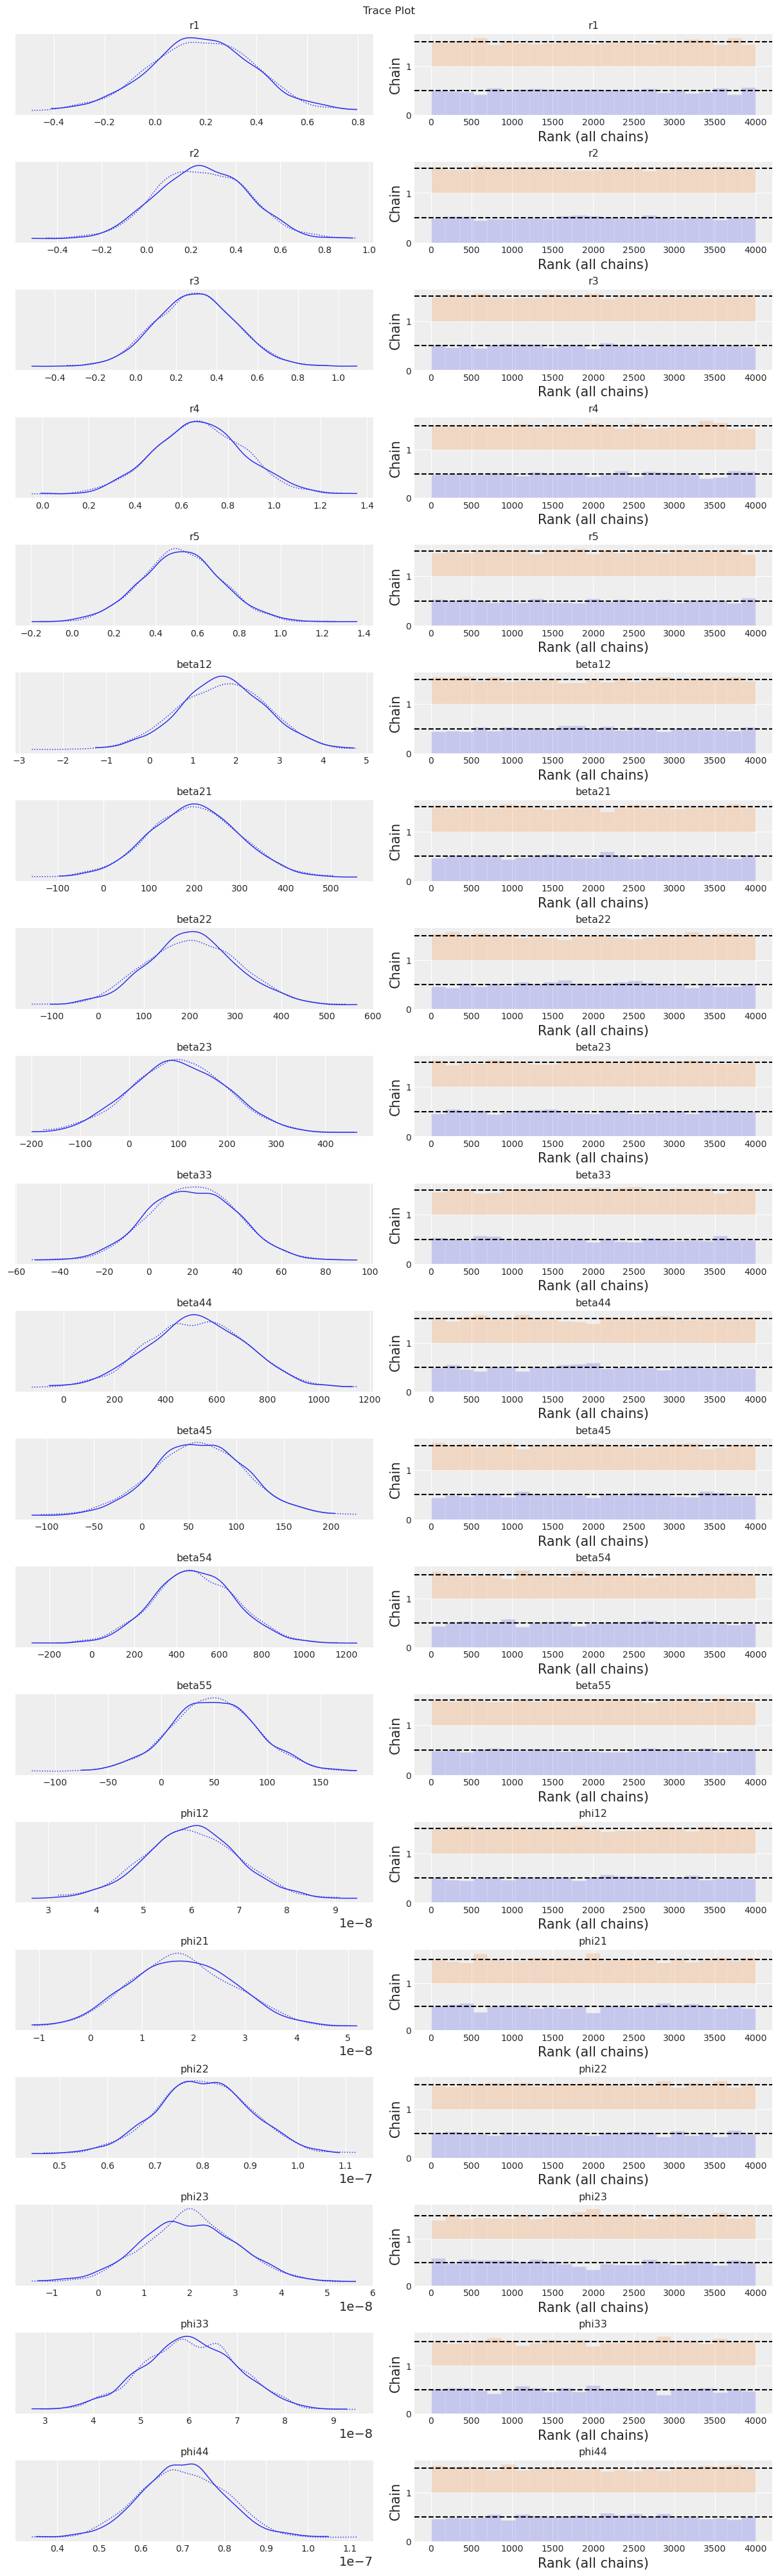

In [30]:
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot");

In [24]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r1,1.800000e-01,0.201,-0.207,5.440000e-01,0.002,0.003,8931.0,2782.0,1.0
r2,2.490000e-01,0.204,-0.149,6.200000e-01,0.002,0.002,9434.0,2621.0,1.0
r3,3.000000e-01,0.201,-0.090,6.530000e-01,0.002,0.002,10957.0,2867.0,1.0
r4,6.800000e-01,0.201,0.311,1.068000e+00,0.002,0.001,12278.0,2744.0,1.0
r5,5.190000e-01,0.202,0.156,9.080000e-01,0.002,0.002,12611.0,2992.0,1.0
beta12,1.698000e+00,1.007,-0.134,3.656000e+00,0.010,0.009,10497.0,2474.0,1.0
beta21,2.005280e+02,99.724,13.838,3.841500e+02,0.891,0.908,12466.0,2582.0,1.0
beta22,2.055160e+02,101.517,9.925,3.875980e+02,0.947,0.847,11491.0,3097.0,1.0
beta23,9.933100e+01,101.125,-88.222,2.871590e+02,0.937,1.221,11670.0,2818.0,1.0
beta33,2.030000e+01,20.930,-21.084,5.872600e+01,0.188,0.259,12281.0,2786.0,1.0


In [31]:
pm.summary(trace, var_names=["phi12"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi12,0.0,0.0,0.0,0.0,0.0,0.0,3976.0,2619.0,1.0


array([[<Axes: title={'center': 'phi12'}>,
        <Axes: title={'center': 'phi12'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

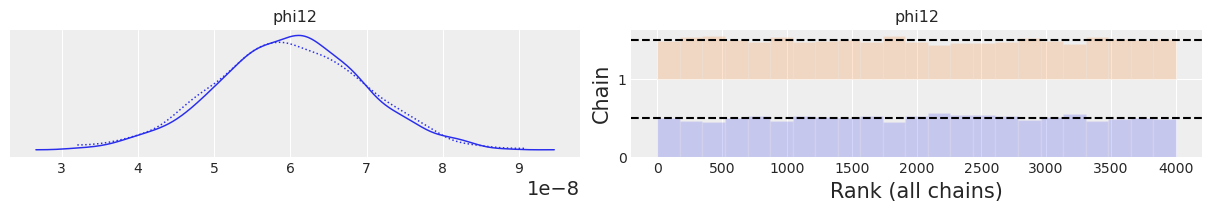

In [32]:
az.plot_trace(trace,var_names=["phi12"], kind="rank_bars")